In [1]:
%matplotlib inline

dataset = 'svhn'
clsimb = [2, 7] # [2, 7], [2, 3, 4], [3, 3, 3]

filename = '{}_clsimb9c{}_42_fedprox'.format(dataset, ''.join(str(x) for x in clsimb))

gpu = 2

In [2]:
import copy
import json
import logging
import os
import random
import time
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, Subset, DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets

In [3]:
seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = True
try:
    torch.use_deterministic_algorithms(False)
except AttributeError:
    torch.set_deterministic(False)

In [4]:
path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(path_root, 'data')
path_logs = os.path.join(path_root, 'logs')
path_models = os.path.join(path_root, 'models', filename)
path_results = os.path.join(path_root, 'results', filename)

for p in [path_data, path_logs, path_models, path_results]:
    os.makedirs(p, exist_ok=True)

In [5]:
logger = logging.getLogger(filename)
logger.setLevel(logging.INFO)

streamformatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
streamhandler = logging.StreamHandler()
streamhandler.setFormatter(streamformatter)
logger.addHandler(streamhandler)

fileformatter = logging.Formatter('%(message)s')
filehandler = logging.FileHandler(os.path.join(path_logs, filename + '.log'), mode='w')
filehandler.setFormatter(fileformatter)
logger.addHandler(filehandler)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        return data, target, idx

    def __len__(self):
        return len(self.dataset)

In [7]:
if dataset == 'cifar10':
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([x / 255 for x in [125.3, 123, 113.9]], [x / 255 for x in [63, 62.1, 66.7]])
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([x / 255 for x in [125.3, 123, 113.9]], [x / 255 for x in [63, 62.1, 66.7]])
    ])

    train_dataset = datasets.CIFAR10(path_data, train=True, transform=train_transform, download=True)
    custom_dataset = CustomDataset(train_dataset)
    test_dataset = datasets.CIFAR10(path_data, train=False, transform=test_transform)
    
elif dataset == 'svhn':
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614))
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614))
    ])

    train_dataset = datasets.SVHN(path_data, split='train', transform=train_transform, download=True)
    custom_dataset = CustomDataset(train_dataset)
    test_dataset = datasets.SVHN(path_data, split='test', transform=test_transform, download=True)
    
elif dataset == 'fmnist':
    train_transform = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

    train_dataset = datasets.FashionMNIST(path_data, train=True, transform=train_transform, download=True)
    custom_dataset = CustomDataset(train_dataset)
    test_dataset = datasets.FashionMNIST(path_data, train=False, transform=test_transform)

elif dataset == 'mnist':
    train_transform = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

    train_dataset = datasets.MNIST(path_data, train=True, transform=train_transform, download=True)
    custom_dataset = CustomDataset(train_dataset)
    test_dataset = datasets.MNIST(path_data, train=False, transform=test_transform)

Using downloaded and verified file: /home/hgato/projects/benchmark/data/train_32x32.mat
Using downloaded and verified file: /home/hgato/projects/benchmark/data/test_32x32.mat


In [8]:
with open(os.path.join(path_data, '{}_clsimb9c{}_42.json'.format(dataset, ''.join(str(x) for x in clsimb)))) as f:
    indices = json.load(f)

In [9]:
batch_size, num_workers = 128, 0

inferloaders, subset_indices = {}, []
for k, v in indices.items():
    infersubset = Subset(custom_dataset, v['index'])
    inferloaders[k] = DataLoader(infersubset, batch_size=batch_size, num_workers=num_workers)
    subset_indices.extend(v['index'])

train_subset = Subset(train_dataset, indices=subset_indices)
fed_trainloader = DataLoader(train_subset, batch_size=batch_size, num_workers=num_workers)
    
try:
    train_labels = np.asarray(custom_dataset.dataset.targets)
    test_labels = test_dataset.targets
except AttributeError:
    train_labels = np.asarray(custom_dataset.dataset.labels)
    test_labels = test_dataset.labels
subset_classes = np.unique(train_labels[subset_indices])
boolarr = [True if y in subset_classes else False for y in test_labels]
subset_indices = np.arange(len(test_dataset))[boolarr]
test_subset = Subset(test_dataset, indices=subset_indices)
testloader = DataLoader(test_subset, batch_size=batch_size, num_workers=num_workers)

In [10]:
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=kernel_size, stride=1, padding=padding, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_channel)

        self.shortcut = nn.Sequential()
        if (stride != 1) or (in_channel != self.expansion * out_channel):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, self.expansion * out_channel, kernel_size=1, stride=stride, bias=bias),
                nn.BatchNorm2d(self.expansion * out_channel)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [11]:
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=1, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, self.expansion * out_channel, kerenel_size=1, bias=bias)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channel)

        self.shortcut = nn.Sequential()
        if (stride != 1) or (in_channel != self.expansion * out_channel):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, self.expansion * out_channel, kernel_size=1, stride=stride, bias=bias),
                nn.BatchNorm2d(self.expansion * out_channel)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, in_channel=3, out_channels=[64, 128, 256, 512], num_blocks=[2, 2, 2, 2], strides=[1, 2, 2, 2], num_classes=10):
        super().__init__()
        self.in_channel = out_channels[0]

        self.conv1 = nn.Conv2d(in_channel, out_channels[0], kernel_size=3, stride=strides[0], padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels[0])
        
        self.block1 = self._make_layer(block, out_channels[0], num_blocks[0], strides[0])
        self.block2 = self._make_layer(block, out_channels[1], num_blocks[1], strides[1])
        self.block3 = self._make_layer(block, out_channels[2], num_blocks[2], strides[2])
        self.block4 = self._make_layer(block, out_channels[3], num_blocks[3], strides[3])
        
        self.linear = nn.Linear(out_channels[-1] * block.expansion, num_classes)

    def _make_layer(self, block, out_channel, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channel, out_channel, stride=stride))
            self.in_channel = out_channel * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [13]:
def average_weights(w):
    w_avg = copy.deepcopy(w[0])
        
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], float(len(w)))
        
    return w_avg

In [14]:
def train(model, loader, epochs, lr, weight_decay, criterion, device, global_model, mu=0.01):
    epoch_losses = []
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    global_params = list(global_model.parameters())
    
    model.train()
    
    for ep in range(epochs):
        batch_losses = []
        
        for inputs, labels, _ in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            model.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = loss.mean()
            
            prox_reg = 0.0
            for i, param in enumerate(model.parameters()):
                prox_reg += ((mu / 2) * torch.norm((param - global_params[i])) ** 2)
            loss += prox_reg
            
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())

        epoch_losses.append(sum(batch_losses) / len(batch_losses))
        
    local_weights = model.state_dict()

    return local_weights, epoch_losses

In [15]:
def inference(model, loader, criterion, device):
    avg_loss, correct, num_samples = 0, 0, 0

    model.eval()
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss = loss.mean()
            avg_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct += torch.sum(torch.eq(predicted, labels)).item()
            num_samples += len(labels)

    acc = correct / num_samples
    avg_loss /= len(loader)
    
    return acc, avg_loss

In [16]:
def infer_train(model, loader, device, match_history, flag=False):
    forgettables = []
    correct, total = 0, 0

    model.eval()
    
    with torch.no_grad():
        for inputs, labels, indices in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            match = predicted.eq(labels)
            match = match.type(torch.IntTensor)
            total += len(indices)
            
            for j, idx in enumerate(indices):
                sample_history = match_history.get(idx.item(), [])
                sample_history.append(match[j].item())
                match_history[idx.item()] = sample_history
                correct += match[j].item()
                if flag is True:
                    try:
                        if match[j].item() - sample_history[-2] == -1:
                            forgettables.append(idx.item())
                    except IndexError:
                        continue
            
    acc = correct / total
            
    return match_history, forgettables, acc

In [17]:
def formatfloats(li):
    new = [float(f'{e:>8.4f}') for e in li]
    return new

In [18]:
resnet9 = {'block': ResidualBlock, 'num_blocks': [1, 1, 1, 1]}
resnet18 = {'block': ResidualBlock, 'num_blocks': [2, 2, 2, 2]}
resnet34 = {'block': ResidualBlock, 'num_blocks': [3, 4, 6, 3]}
resnet50 = {'block': Bottleneck, 'num_blocks': [3, 4, 6, 3]}
resnet101 = {'block': Bottleneck, 'num_blocks': [3, 4, 23, 3]}
resnet152 = {'block': Bottleneck, 'num_blocks': [3, 8, 36, 3]}

In [19]:
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')

In [20]:
resnet = resnet9.copy()

out_channels = [64, 128, 256, 512]
strides = [1, 2, 2, 2]
in_channel = 3

num_classes = 10

fed_model = ResNet(resnet['block'], in_channel=in_channel, out_channels=out_channels, num_blocks=resnet['num_blocks'], strides=strides, num_classes=num_classes)
fed_weights = fed_model.state_dict()

fed_model.to(device)
criterion = nn.CrossEntropyLoss(reduction='none').to(device)

In [21]:
rounds = 200
epochs = 10
lr = 0.001
wdecay = 0

logger.info(f'\nAlgorithm: FedProx\nClient Split: {clsimb}\nDataset: {dataset}\nModel: ResNet9 | Rounds: {rounds} | Epochs: {epochs} | LR: {lr}\n')

train_accs, train_losses, test_accs, test_losses = [], [], [], []
match_history, round_forget_history = {}, []
forget_cnt_per_client = [0] * len(indices.keys())

st = time.time()
for r in range(rounds):
    
    round_forget, round_samples = 0, 0
    forget_history, forgettables = {}, {}
    local_weights, local_losses = [], []
    logger.info(f' | Global Training Round : {r + 1} / {rounds} |')
    
    for i, k in enumerate(indices.keys()):
        match_history, forgettables, global_acc = infer_train(fed_model, inferloaders[k], device, match_history, flag=True)

        fed_model.train()
        
        sampler_idx = indices[k]['index'].copy()
        sampler = SubsetRandomSampler(sampler_idx)

        trainloader = DataLoader(custom_dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
        
        local_model = copy.deepcopy(fed_model)
        w, ls = train(local_model, trainloader, epochs, lr, wdecay, criterion, device, fed_model, mu=0.01)

        local_weights.append(copy.deepcopy(w))
        train_losses.append(ls)
        
        match_history, _, local_acc = infer_train(local_model, inferloaders[k], device, match_history, flag=False)
        train_accs.append(local_acc)
        
        forget_cnt = len(forgettables)
        round_forget += forget_cnt
        forget_cnt_per_client[int(k)] = forget_cnt
        round_samples += len(indices[k]['index'])
        
        logger.info('  |-- [Party {:>1}] Average Train Loss: {:>8.4f} Train Accuracy: global {:>6.2f}% local {:>6.2f}% ... {:>4} forgettables out of {:>4} ({:>5.2f}%) ... total data used {:>4}'.format(
            i + 1, sum(ls) / len(ls), 100 * global_acc, 100 * local_acc, forget_cnt, len(indices[k]['index']), 100 * forget_cnt / len(indices[k]['index']), len(sampler_idx)
        ))
        logger.info('  |--    Epoch Losses ({:>2}): {}'.format(epochs, formatfloats(ls)))
        
    fed_weights = average_weights(local_weights)
    fed_model.load_state_dict(fed_weights)
    train_acc, _ = inference(fed_model, fed_trainloader, criterion, device)
    
    if (r + 1) % 50 == 0:
        torch.save(fed_model.state_dict(), os.path.join(path_models, filename + f'_round{r+1}.pth'))
    
    test_acc, test_ls = inference(fed_model, testloader, criterion, device)
    test_accs.append(test_acc)
    test_losses.append(test_ls)
    round_forget_history.append(round_forget)
    logger.info('    |---- Number of Forgettables: {} ({:.2f}%)'.format(round_forget, 100 * round_forget / round_samples))
    logger.info('    |---- Train Accuracy: {:>.2f}%'.format(100 * train_acc))
    logger.info('    |---- Test Accuracy: {:>.2f}%'.format(100 * test_acc))
    logger.info('    |---- Test Loss: {:.4f}'.format(test_ls))
    logger.info('    |---- Elapsed time: {}'.format(timedelta(seconds=time.time()-st)))
    logger.info(f'\nTest Acc: Max {np.max(test_acc) * 100:.4f}% ({np.argmax(test_accs)+1} round) | Last {test_accs[-1] * 100:.4f}% | Avg {np.mean(test_accs) * 100:.4f}% ({np.argmax(test_accs > np.mean(test_accs))+1} round)\n')

2021-09-01 13:25:35,600 - INFO - 
Algorithm: FedProx
Client Split: [2, 7]
Dataset: svhn
Model: ResNet9 | Rounds: 200 | Epochs: 10 | LR: 0.001

2021-09-01 13:25:35,604 - INFO -  | Global Training Round : 1 / 200 |
2021-09-01 13:25:54,281 - INFO -   |-- [Party 1] Average Train Loss:   0.7681 Train Accuracy: global   0.00% local  91.17% ...    0 forgettables out of 2130 ( 0.00%) ... total data used 2130
2021-09-01 13:25:54,285 - INFO -   |--    Epoch Losses (10): [1.3025, 1.08, 0.9221, 0.8202, 0.7564, 0.6738, 0.5831, 0.5354, 0.5532, 0.4544]
2021-09-01 13:26:10,699 - INFO -   |-- [Party 2] Average Train Loss:   0.7109 Train Accuracy: global   0.00% local  93.00% ...    0 forgettables out of 2130 ( 0.00%) ... total data used 2130
2021-09-01 13:26:10,700 - INFO -   |--    Epoch Losses (10): [1.2393, 1.0578, 0.8922, 0.7674, 0.6718, 0.5857, 0.5039, 0.4771, 0.4701, 0.4436]
2021-09-01 13:26:27,102 - INFO -   |-- [Party 3] Average Train Loss:   0.5436 Train Accuracy: global   0.00% local  91.41% 

In [24]:
train_losses = np.asarray(train_losses)
train_accs = np.asarray(train_accs)

with open(os.path.join(path_results, f'{filename}_tr_ls.npy'), 'wb') as f:
    np.save(f, train_losses)
with open(os.path.join(path_results, f'{filename}_tr_acc.npy'), 'wb') as f:
    np.save(f, train_accs)
with open(os.path.join(path_results, f'{filename}_te_ls.npy'), 'wb') as f:
    np.save(f, test_losses)
with open(os.path.join(path_results, f'{filename}_te_acc.npy'), 'wb') as f:
    np.save(f, test_accs)

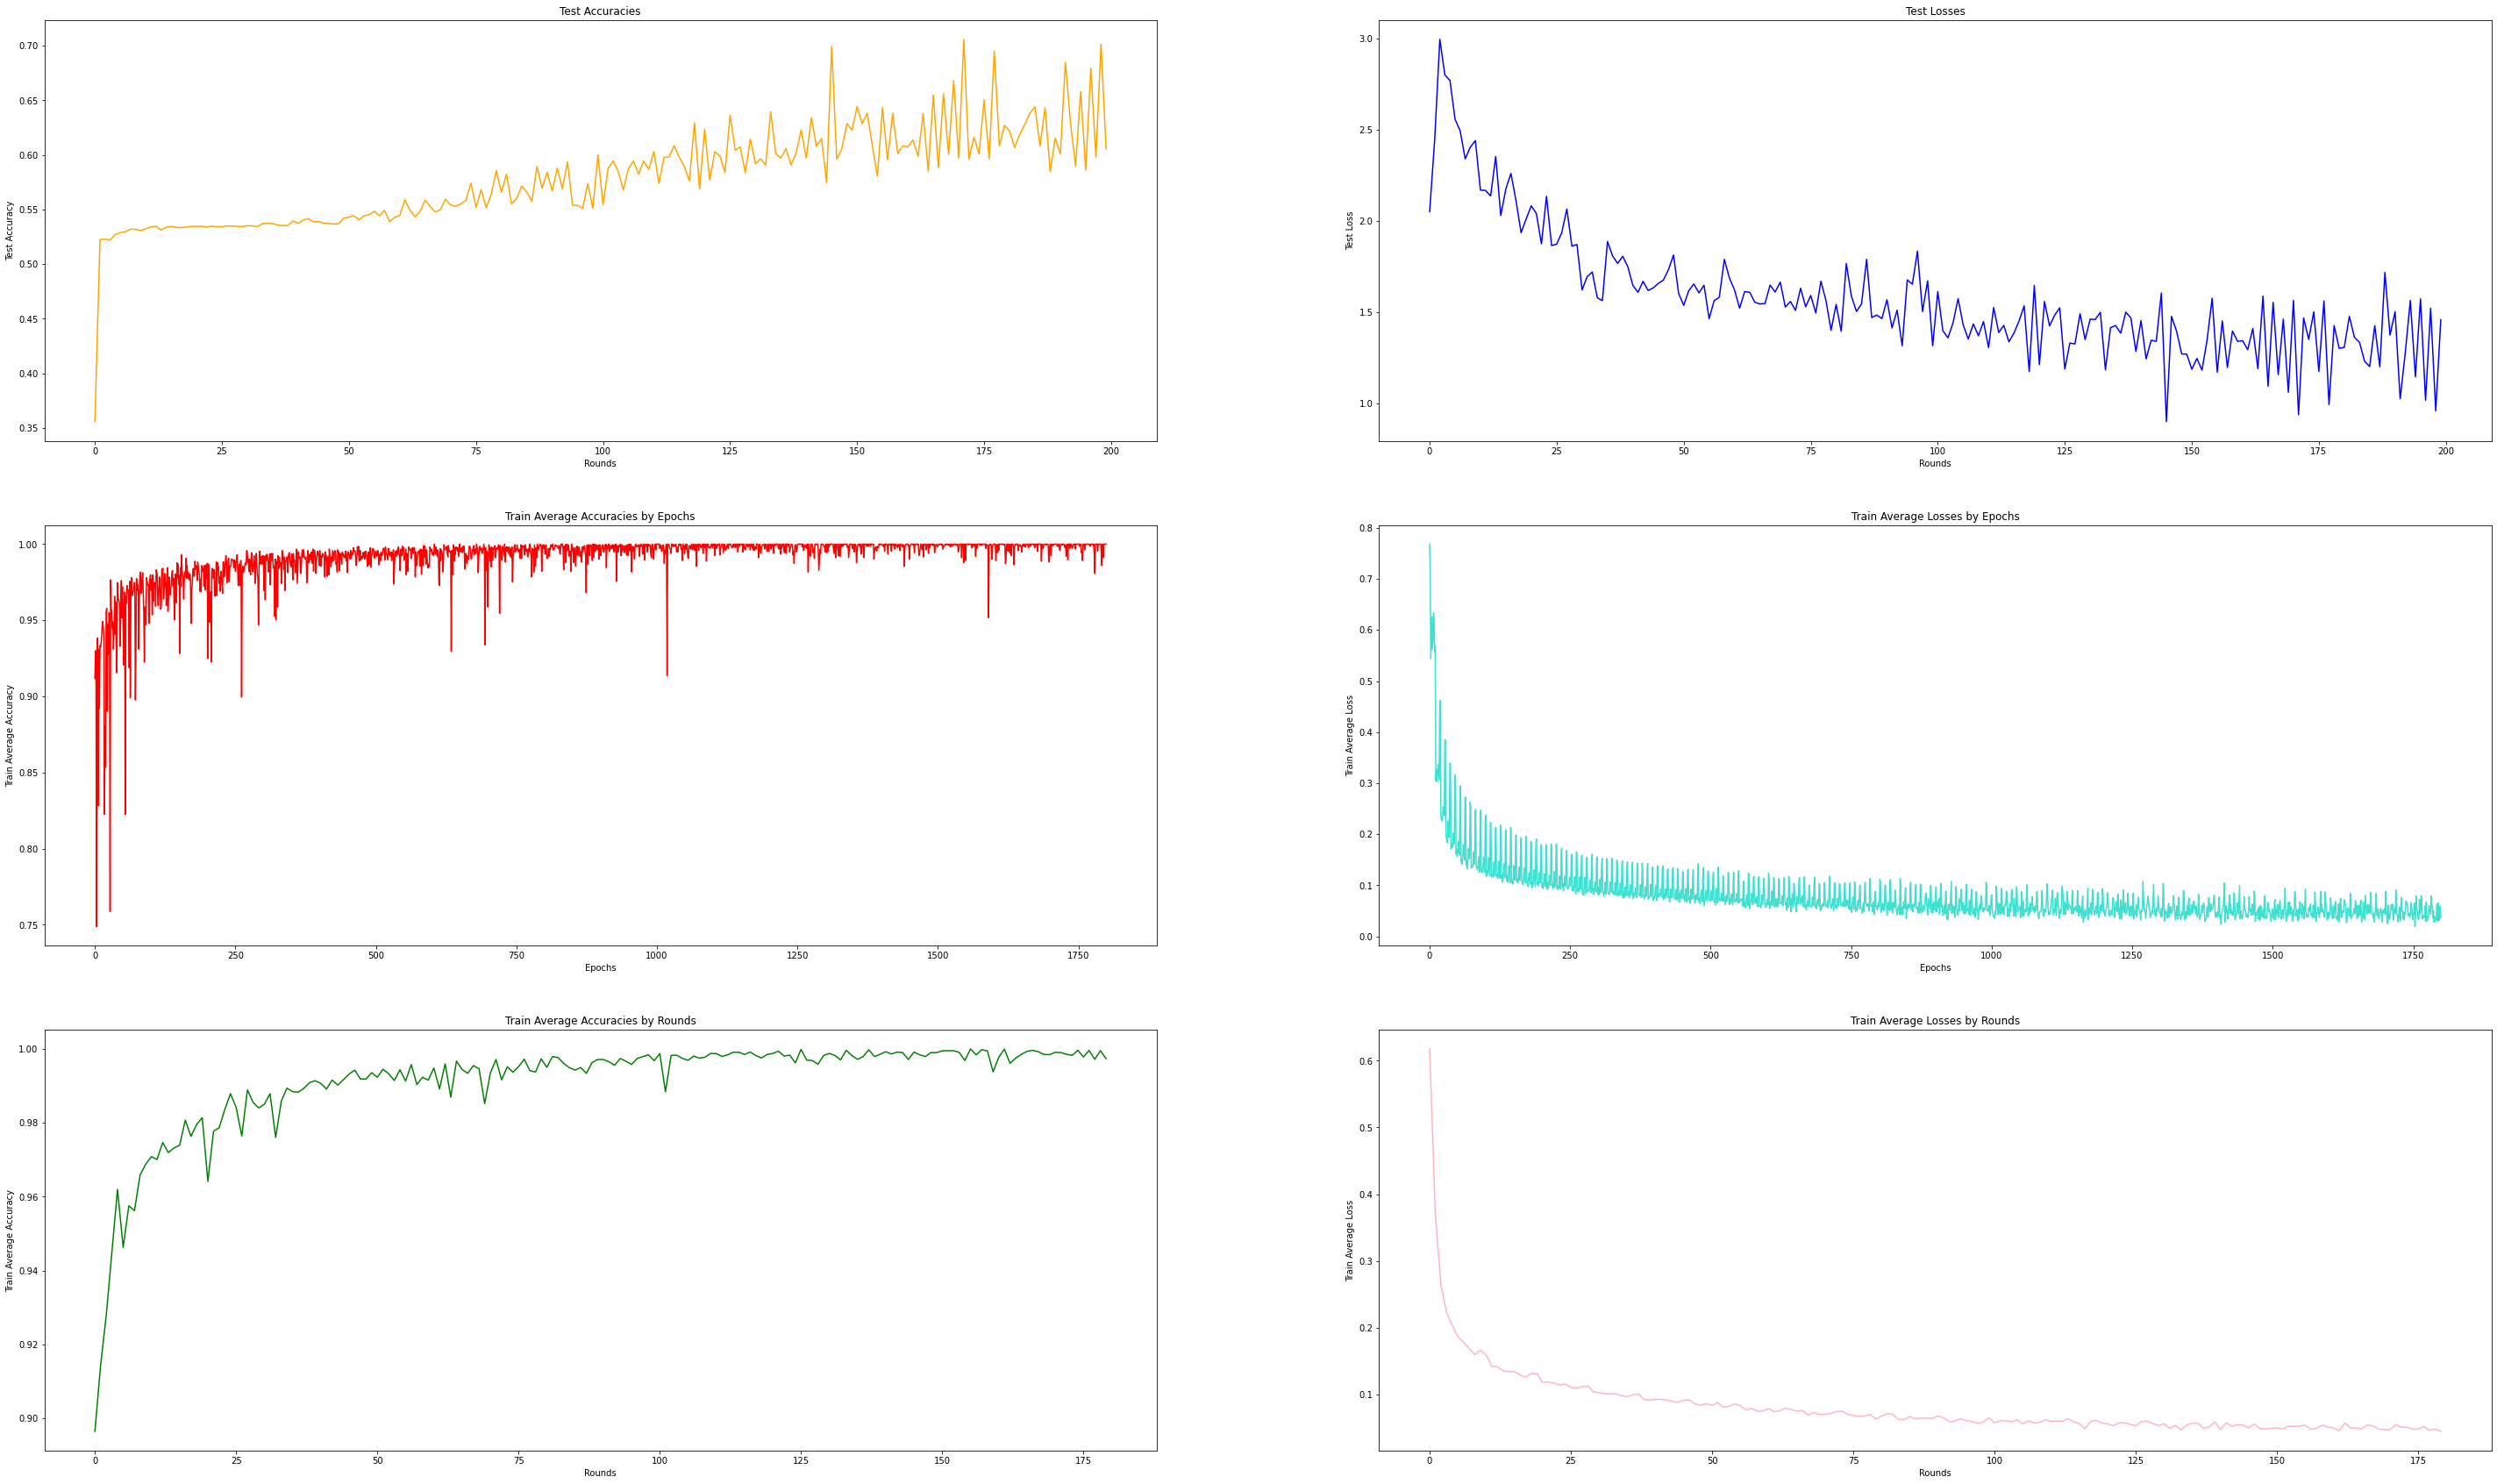

In [25]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(50, 30))
axs = axs.ravel()

axs[0].plot(test_accs, c='orange')
axs[0].set_title('Test Accuracies')
axs[0].set_xlabel('Rounds')
axs[0].set_ylabel('Test Accuracy')
axs[1].plot(test_losses, c='blue')
axs[1].set_title('Test Losses')
axs[1].set_xlabel('Rounds')
axs[1].set_ylabel('Test Loss')
axs[2].plot(train_accs, c='red')
axs[2].set_title('Train Average Accuracies by Epochs')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Train Average Accuracy')
axs[3].plot(train_losses.mean(axis=1), c='turquoise')
axs[3].set_title('Train Average Losses by Epochs')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('Train Average Loss')
axs[4].plot(np.mean(train_accs.reshape(-1, 10), axis=1), c='green')
axs[4].set_title('Train Average Accuracies by Rounds')
axs[4].set_xlabel('Rounds')
axs[4].set_ylabel('Train Average Accuracy')
axs[5].plot(train_losses.mean(axis=1).reshape(-1, 10).mean(axis=1), c='lightpink')
axs[5].set_title('Train Average Losses by Rounds')
axs[5].set_xlabel('Rounds')
axs[5].set_ylabel('Train Average Loss')

plt.show()